In [1]:
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import os

In [2]:
# load environment variables from .env file for project
dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)

True

In [3]:
data_directory = os.getenv("OUTPUT_DIRECTORY")

In [4]:
os.listdir(data_directory)

['OmzetEansCoicopsPlus_202206_202308.parquet',
 'converted_csvs',
 'OmzetEansCoicopsLidl_202007_202202.parquet',
 'OutputEansCoicopsPlus_202107_202205.parquet',
 'OmzetEansCoicopsPlus_202107_202205.parquet',
 'OmzetEansCoicopsLidl_202203_202308.parquet',
 'KassabonPlus_va_202201.parquet',
 'OmzetEansCoicopsLidl_2018_202006.parquet']

# Analysis of PLUS data

We can see there are several files with PLUS data. Let's combine them first for an analysis.

In [5]:
plus_revenue_files = [os.path.join(data_directory, filename) for filename in os.listdir(data_directory) if filename.startswith("Omzet") and "Plus" in filename]
plus_revenue_files

['/data/projecten/ssi/data/OmzetEansCoicopsPlus_202206_202308.parquet',
 '/data/projecten/ssi/data/OmzetEansCoicopsPlus_202107_202205.parquet']

We have two files for Plus, see if they have the same headers:

In [8]:
for revenue_file in plus_revenue_files:
    print(list(pd.read_parquet(revenue_file, engine="pyarrow").columns))

['bg_number', 'month', 'coicop_number', 'coicop_name', 'isba_number', 'isba_name', 'esba_number', 'esba_name', 'rep_id', 'ean_number', 'ean_name', 'revenue', 'amount']
['bg_number', 'month', 'coicop_number', 'coicop_name', 'isba_number', 'isba_name', 'esba_number', 'esba_name', 'rep_id', 'ean_number', 'ean_name', 'revenue', 'amount']


They have the same headers. We can now combine them into one dataframe.

In [19]:
plus_df = pd.concat([pd.read_parquet(revenue_file, engine="pyarrow") for revenue_file in plus_revenue_files])
plus_df = plus_df.sort_values(by=["bg_number","month", "coicop_number"], ascending=[True, True, True])
plus_df.to_parquet(os.path.join(data_directory, "ssi_omzet_eans_coicops_plus_202107_202308.parquet"), engine="pyarrow")

In [20]:
plus_df.head(20)

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount
142724,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43675579,2270950000000,## BIO TOVERRIJST,5.810000,7.0
142725,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43896123,2271870000000,## SNELKOOKRIJST,1.200000,2.0
142726,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43259183,2271940000000,## SNELKOOKRIJST,1.200000,2.0
142727,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,26248778,2272590000000,## RIJST,13.530000,11.0
142728,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43675979,2274280000000,## BIO TOVERRIJST,3.320000,4.0
142729,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43676149,2274500000000,## SNELKOOKRIJST,4.200000,7.0
142730,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43675890,2275140000000,## SNELKOOKRIJST,10.010000,13.0
142731,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43453454,2275330000000,## ZILVERVLIESRIJST,1.500000,2.0
142732,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43896985,2276680000000,## 1 MINUUT WITTE RI,1.100000,2.0
142733,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43676520,2276700000000,## BIO TOVERRIJST,4.980000,6.0


In [21]:
plus_df.tail(20)

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount
3422491,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,9648021,2138700000000,LOKAAL Pietermanfilet 1 KG,80.150002,16.0
3422492,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,63407346,2138770000000,LOKAAL Garnalenkroket Noors 5 ST,20.969999,3.0
3422493,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,9648023,2138800000000,LOKAAL Heekfilet 1 KG,93.440002,12.0
3422494,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,18967374,2138990000000,LOKAAL Zalmfilet superior zonder huid 1 ST,562.169983,60.0
3422495,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,25294940,2139030000000,LOKAAL Hollandse Garnalen 1 KG,15.120000,3.0
3422496,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,23986365,2139270000000,LOKAAL Scholfilet 1 KG,160.389999,17.0
3422497,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,9739823,2139300000000,LOKAAL Mahi mahi filet 1 KG,89.489998,7.0
3422498,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,48425160,2139470000000,LOKAAL Joop's Feestschoteltje 1 GR,209.580002,42.0
3422499,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,10230913,2139480000000,LOKAAL Black tiger met kop 1 KG,18.870001,2.0
3422500,901027,202308,999999,Onbekend,999999701,Niet in te delen,9451,IJs bediening,10335491,2139600000000,LOKAAL Forelfilet 1 KG,2.370000,1.0


Now we have the combined dataset, let's check the length of the COICOP numbers again:

In [23]:
plus_df.coicop_number.str.len().value_counts().reset_index()

,coicop_number,count
0,5,5045254
1,6,771875


Like in the LIDL dataset, we have COICOP numbers with lenght 5 and with length 6. There are no COICOP numbers of length 0, however. Let's explore some COICOP numbers with length 5:

In [25]:
plus_df[plus_df.coicop_number.str.len() == 5].head(10)

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount
142724,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43675579,2270950000000,## BIO TOVERRIJST,5.81,7.0
142725,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43896123,2271870000000,## SNELKOOKRIJST,1.20,2.0
142726,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43259183,2271940000000,## SNELKOOKRIJST,1.20,2.0
142727,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,26248778,2272590000000,## RIJST,13.53,11.0
142728,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43675979,2274280000000,## BIO TOVERRIJST,3.32,4.0
142729,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43676149,2274500000000,## SNELKOOKRIJST,4.20,7.0
142730,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43675890,2275140000000,## SNELKOOKRIJST,10.01,13.0
142731,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43453454,2275330000000,## ZILVERVLIESRIJST,1.50,2.0
142732,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43896985,2276680000000,## 1 MINUUT WITTE RI,1.10,2.0
142733,901027,202107,11110,Rijst,11110701,Rijst,3711,Witte rijst,43676520,2276700000000,## BIO TOVERRIJST,4.98,6.0


And also some with length 6:

In [26]:
plus_df[plus_df.coicop_number.str.len() == 6].head(10)

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount
1272,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,16702279,2278890000000,## HERBAL TWIST TAND,2.500000,1.0
1273,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,43676600,2278910000000,## TOTAL WHITENING,2.000000,1.0
1274,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,39918012,2279170000000,## GEVOELIG EN TANDV,6.000000,2.0
1275,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,43676343,2279800000000,## MAX FRESH BLUE,15.500000,10.0
1276,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,43677245,2282840000000,## SENSITIVE WHITENI,22.500000,10.0
1277,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,43896878,2282870000000,## TANDPASTA GEV ORI,3.220000,1.0
1278,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,9631354,4084500740303,Oral-B Tandpasta 3d white luxe perfection TU ...,762.570007,183.0
1279,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,14336799,4210201154730,Oral-B Stages power EB10 Frozen refill SW 2ST,812.020020,90.0
1280,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,9590730,5054563014276,Sensodyne Deep clean TU 75ML,6.960000,2.0
1281,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,9590737,5054563026170,Parodontax Tandpasta Fluoride Duopack BX 150ML,80.910004,9.0


Let's explore the different COICOP numbers with length 6 again:

In [27]:
plus_df[plus_df.coicop_number.str.len() == 6].coicop_number.value_counts()

coicop_number
999999    708262
121320     58242
123290      5371
Name: count, dtype: int64

It looks like there are only three different values for COICOP numbers with 6 digits:
- 999999
- 121320     
- 123290    

`999999` and `121320` were also present in the LIDL dataset. `123290` is a new value. Let's check the COICOP numbers with length 5:

In [28]:
plus_df[plus_df.coicop_number.str.len() == 5].coicop_number.value_counts()

coicop_number
11140    544080
11270    405264
11130    387874
11940    310996
11450    239013
          ...  
61290       585
83020       305
11230       211
31310       187
94250        42
Name: count, Length: 81, dtype: int64

There are 81 unique COICOP numbers with length 5, there seem to be a bit more COICOP categories than for LIDL:

In [29]:
plus_df[plus_df.coicop_number.str.len() == 5].coicop_number.nunique()

81

It looks like again the leading zeroes for the COICOP divisions are ommited:

In [31]:
plus_df[plus_df.coicop_number.str.len() == 5].coicop_number.str.startswith("0").sum()

0

Check the product descriptions for COICOP division 12, and check if they are the same categories as for LIDL:

In [32]:
plus_df[(plus_df.coicop_number.str.len() == 6) & (plus_df.coicop_number.str.startswith("12"))].head(10)

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount
1272,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,16702279,2278890000000,## HERBAL TWIST TAND,2.500000,1.0
1273,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,43676600,2278910000000,## TOTAL WHITENING,2.000000,1.0
1274,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,39918012,2279170000000,## GEVOELIG EN TANDV,6.000000,2.0
1275,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,43676343,2279800000000,## MAX FRESH BLUE,15.500000,10.0
1276,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,43677245,2282840000000,## SENSITIVE WHITENI,22.500000,10.0
1277,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,43896878,2282870000000,## TANDPASTA GEV ORI,3.220000,1.0
1278,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,9631354,4084500740303,Oral-B Tandpasta 3d white luxe perfection TU ...,762.570007,183.0
1279,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,14336799,4210201154730,Oral-B Stages power EB10 Frozen refill SW 2ST,812.020020,90.0
1280,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,9590730,5054563014276,Sensodyne Deep clean TU 75ML,6.960000,2.0
1281,901027,202107,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320701,Mondverzorging,6041,Tandpasta,9590737,5054563026170,Parodontax Tandpasta Fluoride Duopack BX 150ML,80.910004,9.0


Restore leading zeroes for COICOP division:

In [34]:
plus_df.loc[plus_df.coicop_number.str.len() == 5, 'coicop_number'] = plus_df[plus_df.coicop_number.str.len() == 5].coicop_number.apply(lambda s: f"0{s}")

Check if all COICOP numbers are of length 6 now:

In [35]:
plus_df.coicop_number.str.len().value_counts().reset_index()

,coicop_number,count
0,6,5817129


Derive COICOP division for Plus:

In [37]:
plus_df['coicop_division'] = plus_df[plus_df.coicop_number.str.len() == 6].coicop_number.str[:2]
plus_df.head()

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount,coicop_division
142724,901027,202107,011110,Rijst,11110701,Rijst,3711,Witte rijst,43675579,2270950000000,## BIO TOVERRIJST,5.81,7.0,01
142725,901027,202107,011110,Rijst,11110701,Rijst,3711,Witte rijst,43896123,2271870000000,## SNELKOOKRIJST,1.20,2.0,01
142726,901027,202107,011110,Rijst,11110701,Rijst,3711,Witte rijst,43259183,2271940000000,## SNELKOOKRIJST,1.20,2.0,01
142727,901027,202107,011110,Rijst,11110701,Rijst,3711,Witte rijst,26248778,2272590000000,## RIJST,13.53,11.0,01
142728,901027,202107,011110,Rijst,11110701,Rijst,3711,Witte rijst,43675979,2274280000000,## BIO TOVERRIJST,3.32,4.0,01


Count the number of products for each COICOP division:

In [38]:
plus_df.coicop_division.value_counts()

coicop_division
01    4367680
99     708262
09     270661
02     257110
05      91532
12      63613
06      38828
03      15689
08       3754
Name: count, dtype: int64

<Axes: xlabel='coicop_division'>

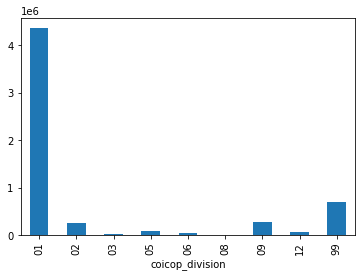

In [39]:
plus_df.coicop_division.value_counts().sort_index().plot(kind="bar")

According to this barchart the following COICOP divisions are present in the Plus dataset:
- 01 Food and non-alcoholic beverages
- 02 Alcoholic beverages, tobacco and narcotics
- 03 Clothing and footwear
- 05 Furnishings, household equipment and routine household maintenance
- 06 Health
- *08 Information and communication* 
- 09 Recreation, sport and culture
- 12 Insurance and financial services
- 99 Does not exist in COICOP divisions, this is probably some CBS specific category?

As we have seen earlier, the division 12 present in the list here, is probably mixed up with COICOP division 13 "Personal care, social protection and miscellaneous goods and services". There's one extra category (08) in comparison to LIDL. Also the distributions of the products are different to those of LIDL.coicop_division_descriptions = lidl_df.groupby(by="coicop_division")["coicop_name"].value_counts().reset_index()
coicop_division_descriptions

The Plus data also contains a column with COICOP descriptions. Let's see which divisions have which descriptions:

In [40]:
coicop_division_descriptions = plus_df.groupby(by="coicop_division")["coicop_name"].value_counts().reset_index()
coicop_division_descriptions

,coicop_division,coicop_name,count
0,01,Overige bakkerijproducten,544080
1,01,"Gedroogd, gezouten of gerookt vlees",405264
2,01,Brood,387874
3,01,Kant-en-klaarmaaltijden,310996
4,01,Kaas en kwark,239013
...,...,...,...
79,09,Tuinproducten,699
80,09,Diensten op het gebied van fotografie,42
81,12,Artikelen voor persoonlijke hygiëne en wellne...,58242
82,12,Overige artikelen voor persoonlijk gebruik n....,5371


Let's analyze the product types for each COICOP division for Plus:

In [41]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "01"]

,coicop_division,coicop_name,count
0,01,Overige bakkerijproducten,544080
1,01,"Gedroogd, gezouten of gerookt vlees",405264
2,01,Brood,387874
3,01,Kant-en-klaarmaaltijden,310996
4,01,Kaas en kwark,239013
5,01,Rund- en kalfsvlees,234800
6,01,Verse of gekoelde groenten behalve aardappele...,226929
7,01,Pluimveevlees,178021
8,01,Varkensvlees,157060
9,01,Overige vleesbereidingen,156640


All the products in COICOP division 01 are indeed Food related products

In [42]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "02"]

,coicop_division,coicop_name,count
51,02,Pils,121528
52,02,Gedistilleerde dranken en likeuren,70916
53,02,Wijn van druiven,34368
54,02,Sigaretten,11886
55,02,Shag en andere tabaksproducten,6879
56,02,Licht alcoholisch en alcoholvrij bier,5339
57,02,Sigaren,4534
58,02,Distillatiewijn,1660


And the products in COICOP division 02 are either alcoholic beverages or tabacco products. Note that Plus also sells tabacco products whereas Lidl does not. Tabacco products should therefore not occur on a Lidl receipt.

In [43]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "03"]

,coicop_division,coicop_name,count
59,03,Herenkleding,10394
60,03,Dameskleding,4518
61,03,Wasserijen en stomerijen,590
62,03,Overige kledingartikelen,187


Most products in COICOP division 03 are indeed Clothing products. However, "Wasserijen en stomerijen", i.e. "Washing and drycleaning" refer to services. Not sure these should be present in COICOP division 03.

In [44]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "05"]

,coicop_division,coicop_name,count
63,05,Schoonmaak- en onderhoudsproducten,43913
64,05,Overige niet-duurzame kleine huishoudproducte...,29265
65,05,"Glaswerk, kristal en aardewerk of porselein",8583
66,05,Diverse losse onderdelen,6648
67,05,Overig huishoudtextiel,3123


The products in COICOP division 05 are indeed all related to "Furnishings, household equipment and routine household maintenance". More specifically, they seem related to COICOP groups:
- 5.1 Household textiles
- 5.4 Glassware, tableware and household utensils
- 5.6 Tools and equipment for house and garden

We have to check the futher division in COICOP groups later.

In [45]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "06"]

,coicop_division,coicop_name,count
68,06,Farmaceutische producten,38243
69,06,Overige medische producten n.e.g.,585


Indeed all products in COICOP division 06 are related to "Health".

In [46]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "08"]

,coicop_division,coicop_name,count
70,08,Bezorging van brieven,3449
71,08,Mobiele telefoondiensten,305


Indeed all products in COICOP division 08 are related to "Information and Communication". In specific, they seem to be related to COICOP group `08.3 - Information and communcation services`.

In [47]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "09"]

,coicop_division,coicop_name,count
72,09,Overige schrijfwaren en tekenartikelen,97635
73,09,Planten en bloemen,56772
74,09,Speelgoed en feestartikelen,50841
75,09,Tijdschriften,32021
76,09,Producten voor huisdieren,28111
77,09,Voorbespeelde dragers van beeld of geluid,3610
78,09,Overige non-fictieboeken,930
79,09,Tuinproducten,699
80,09,Diensten op het gebied van fotografie,42


As with LIDL, the products in COICOP division 09 look all related to the broader COICOP description "Recreation, sport and culture". Especially, the products here look part of the following COICOP groups:
- 09.1 Recreational durables
- 09.2 Other recreational goods
- 09.3 Garden products and pets
- 09.4 Recreational services
- 09.7 Newspapers, books and stationery

In [48]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "12"]

,coicop_division,coicop_name,count
81,12,Artikelen voor persoonlijke hygiëne en wellne...,58242
82,12,Overige artikelen voor persoonlijk gebruik n....,5371


Again, the products in COICOP division 12 should be related to "Insurance and financial services". However, it looks like all the products and their descriptions here are instead "Personal care, social protection and miscellaneous goods and services". Thus, we think these products instead should have COICOP_division 13 instead.

In [49]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "99"]

,coicop_division,coicop_name,count
83,99,Onbekend,708262


Again products with "COICOP division" 99 are part of an "unknown" category.